In [20]:
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import linregress


In [2]:
SIZES = ['14m', '70m', '160m', '2.8b', '12b']
CKPTS = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 
         1000, 2000, 3000, 4000, 8000, 13000, 23000 ,32000, 33000, 43000,
         53000, 63000, 64000, 73000, 83000, 93000, 103000, 113000, 123000, 133000,
         143000]
SCALING_SIZES = ['410m', '1.4b', '6.9b']
DATASETS = [1, 2, 3, 4]
DATASET_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


HIDDEN_DIMS = {
    '14m': 128, 
    '70m': 512, 
    '160m': 768, 
    '410m': 1024,
    '1.4b': 2048,
    # '2.8b': 2560, 
    '6.9b': 4096,
    '12b': 5120,
}

MODES = ['sane', 'shuffled']

In [8]:

results_df.columns

Index(['Unnamed: 0', 'pca_mean', 'pca_std', 'pr_mean', 'pr_std', 'twonn_mean',
       'twonn_std', 'mle_mean', 'mle_std', 'mode', 'words_coupled', 'step',
       'D', 'model', 'layer'],
      dtype='object')

In [3]:
results_df = pd.read_csv('results/emily_id_results_all.csv')

  model twonn_mean     pca_mean twonn_std    pca_std
              mean         mean  <lambda>   <lambda>
0  1.4b  32.351116  1106.116667  1.554990   8.818163
1   12b  34.973246  2349.500000  2.320390  21.436418
2   14m  18.397354    58.700000  0.562451   1.019804
3  160m  36.790979   508.050000  1.474257   2.638181
4  410m  29.401837   559.491667  1.662900   4.724405
5  6.9b  35.014134  1972.993750  2.373374  11.896218
6   70m  22.295186   183.733333  0.516140   3.224903
  model twonn_mean     pca_mean twonn_std    pca_std
              mean         mean  <lambda>   <lambda>
0  1.4b  23.917732  1024.791667  1.124150   7.375636
1   12b  24.750278  2190.066667  1.723731  21.455069
2   14m  15.741719    58.733333  0.498711   1.296148
3  160m  26.965320   494.583333  1.000473   3.249615
4  410m  22.243966   515.200000  1.212742   3.544009
5  6.9b  25.056294  1833.962500  1.596835  12.496399
6   70m  18.658563   172.566667  0.528363   2.814249
  model twonn_mean     pca_mean twonn_std    p

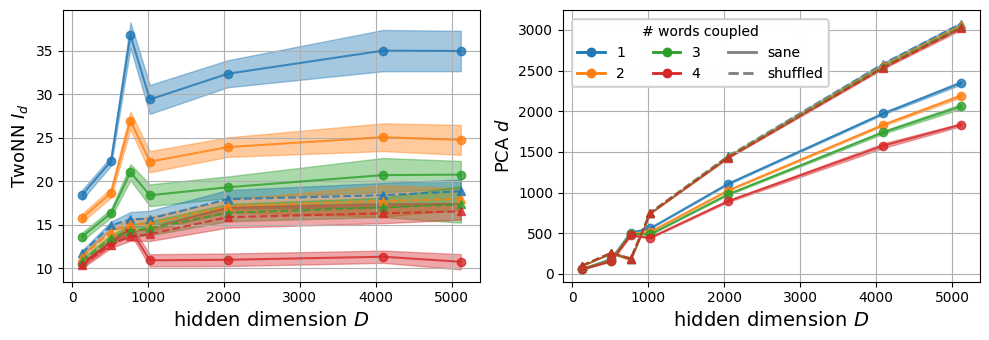

In [11]:
# Take mean over layers.

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

# Make figure
Ds = [HIDDEN_DIMS[model] for model in HIDDEN_DIMS]

for i, mode in enumerate(MODES):
    for ds in DATASETS:
        last_ckpt_df = results_df[(results_df['step']==143000) & (results_df['mode']==mode)]
        last_ckpt_df = last_ckpt_df[last_ckpt_df['words_coupled']==ds]

        # Mean
        agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
        last_ckpt_mean = last_ckpt_df[['model', 'twonn_mean', 'pca_mean']]
        last_ckpt_std = last_ckpt_df[['model', 'twonn_std', 'pca_std']]
        means_df = last_ckpt_mean.groupby('model').agg(['mean'])
        std_df = last_ckpt_std.groupby('model').agg([agg_std])
        means_df = means_df.merge(std_df, on='model')
        means_df = means_df.reset_index()
        print(means_df)
        # Plot one line per datas
        for j, method in enumerate(['twonn', 'pca']):
            ys = np.array([means_df[means_df['model']==model][(f'{method}_mean','mean')] for model in HIDDEN_DIMS])[:,0]
            ystd = np.array([means_df[means_df['model']==model][(f'{method}_std','<lambda>')] for model in HIDDEN_DIMS])[:,0]
            
            axs[j].plot(
                Ds, 
                ys, 
                label=f'{ds}',
                linestyle='--' if mode == 'shuffled' else None,
                marker='o' if mode == 'sane' else '^',
                alpha=0.8,
                color=DATASET_COLORS[ds-1]
            )
            axs[j].fill_between(Ds, ys - ystd, ys + ystd, alpha=0.4, color=DATASET_COLORS[ds-1])
            if method == 'twonn':
                axs[j].set_ylabel(r'TwoNN $I_d$', fontsize=13)
            else:
                axs[j].set_ylabel(r'PCA $d$', fontsize=13)

            axs[j].set_xlabel(r'hidden dimension $D$', fontsize=14)
            axs[j].grid(True)
            # axs[j].set_yticklabels(axs[j].get_yticklabels(), fontsize=10)
            # axs[j].set_xticklabels(axs[j].get_xticklabels(), fontsize=10)

        # Custom legend handles for both subplots
        custom_lines = [Line2D([0], [0], color=color, marker='o', lw=2) for color in DATASET_COLORS] + \
            [Line2D([0], [0], color='gray', lw=2), Line2D([0], [0], color='gray', linestyle='--', lw=2)]
        
        fig.legend(custom_lines, 
                   [1, 2, 3, 4, 'sane', 'shuffled'], 
                   loc='upper center', ncol=3, title='# words coupled', bbox_to_anchor=(0.705,0.95))
        fig.tight_layout()

In [36]:
# Take mean over layers.

# Make figure
Ds = [HIDDEN_DIMS[model] for model in HIDDEN_DIMS]
lin_scores={'r':[], "method":[], 'mode':[], 'k':[], 'p':[], 'slope':[]}
for i, mode in enumerate(MODES):
    for ds in DATASETS:
        last_ckpt_df = results_df[(results_df['step']==143000) & (results_df['mode']==mode)]
        last_ckpt_df = last_ckpt_df[last_ckpt_df['words_coupled']==ds]

        # Mean
        agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
        last_ckpt_mean = last_ckpt_df[['model', 'twonn_mean', 'pca_mean']]
        last_ckpt_std = last_ckpt_df[['model', 'twonn_std', 'pca_std']]
        means_df = last_ckpt_mean.groupby('model').agg(['mean'])
        std_df = last_ckpt_std.groupby('model').agg([agg_std])
        means_df = means_df.merge(std_df, on='model')
        means_df = means_df.reset_index()
        # Plot one line per datas
        for j, method in enumerate(['twonn', 'pca']):
            ys = np.array([means_df[means_df['model']==model][(f'{method}_mean','mean')] for model in HIDDEN_DIMS])[:,0]
            ystd = np.array([means_df[means_df['model']==model][(f'{method}_std','<lambda>')] for model in HIDDEN_DIMS])[:,0]
            #reg_model=LinearRegression().fit(np.array(Ds)[...,None],ys)
            #score=reg_model.score(np.array(Ds)[...,None],ys)
            slope, intercept, r, p, se = linregress(np.array(Ds),ys)
            lin_scores['r'].append(r)
            lin_scores['slope'].append(slope)
            lin_scores['p'].append(p)
            lin_scores['k'].append(ds)
            lin_scores['mode'].append(mode)
            lin_scores['method'].append(method)

In [37]:
import pandas as pd
pd_linscores = pd.DataFrame(lin_scores)
pd_linscores.to_csv('hidden_dim_lin_fit.csv')

In [47]:
pd_linscores[(pd_linscores['method']== 'twonn') & (pd_linscores['mode']== 'shuffled')]

,r,method,mode,k,p,slope
8,0.848782,twonn,shuffled,1,0.015716,0.001097
10,0.848743,twonn,shuffled,2,0.015726,0.001039
12,0.858634,twonn,shuffled,3,0.013354,0.001027
14,0.855862,twonn,shuffled,4,0.013996,0.000994


In [48]:
# Take mean over layers.

# Make figure
Ds = [HIDDEN_DIMS[model] for model in HIDDEN_DIMS]
lin_scores_pile={'r':[], "method":[], 'mode':[],  'p':[], 'slope':[]}
for i, mode in enumerate(['pile']):
    last_ckpt_df = results_df[(results_df['step']==143000) & (results_df['mode']==mode)]
    # Mean
    agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
    last_ckpt_mean = last_ckpt_df[['model', 'twonn_mean', 'pca_mean']]
    last_ckpt_std = last_ckpt_df[['model', 'twonn_std', 'pca_std']]
    means_df = last_ckpt_mean.groupby('model').agg(['mean'])
    std_df = last_ckpt_std.groupby('model').agg([agg_std])
    means_df = means_df.merge(std_df, on='model')
    means_df = means_df.reset_index()
    # Plot one line per datas
    for j, method in enumerate(['twonn', 'pca']):
        ys = np.array([means_df[means_df['model']==model][(f'{method}_mean','mean')] for model in HIDDEN_DIMS])[:,0]
        ystd = np.array([means_df[means_df['model']==model][(f'{method}_std','<lambda>')] for model in HIDDEN_DIMS])[:,0]
        #reg_model=LinearRegression().fit(np.array(Ds)[...,None],ys)
        #score=reg_model.score(np.array(Ds)[...,None],ys)
        slope, intercept, r, p, se = linregress(np.array(Ds),ys)
        lin_scores_pile['r'].append(r)
        lin_scores_pile['slope'].append(slope)
        lin_scores_pile['p'].append(p)
        lin_scores_pile['mode'].append(mode)
        lin_scores_pile['method'].append(method)

In [49]:
pd.DataFrame(lin_scores_pile)

,r,method,mode,p,slope
0,0.953697,twonn,pile,8.641850e-04,0.001712
1,0.999311,pca,pile,2.393194e-08,0.811975
